<a href="https://colab.research.google.com/github/webbigdata-jp/VoiceCore/blob/main/VoiceCore_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [VoiceCore](https://huggingface.co/webbigdata/VoiceCore) Demo.

webbigdata/VoiceCoreをColab上で無料で動かすサンプルスクリプトです  
This is a sample script that runs webbigdata/VoiceCore for free on Colab.  

Enter your Japanese text and we'll create voice wave file.  
日本語のテキストを入力すると、その文章を音声にしたWAF fileを作成します  


## How to run/動かし方

If you are on a github page, click the Open in Colab button at the top of the screen to launch Colab.

あなたが見ているのがgithubのページである場合、画面上部に表示されているOpen in Colabボタンを押してColabを起動してください

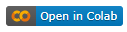

Next, run each cell one by one (i.e. click the "▷" in order as shown in the image below).  
次に、セルを１つずつ実行(つまり、以下の画像のような「▷」を順番にクリック)してください  

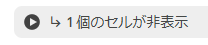


## 1. Install Required Libraries

In [ ]:
%%capture
%%shell
#@title Install Required Libraries

pip install snac transformers scipy

## 2. Setting Up

2つのモデルをダウンロードするためやや時間がかかります  
This will take some time as two models will be downloaded.  

In [ ]:
%%capture
#@title (1)Dependent Libraries and Utility Functions/依存ライブラリとユーティリティ関数
# ======== セル1: 依存ライブラリとユーティリティ関数 ========

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "webbigdata/VoiceCore"

# bfloat16が利用可能かチェックして適切なデータ型を選択
if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
    dtype = torch.bfloat16
else:
    dtype = torch.float16

model = AutoModelForCausalLM.from_pretrained(
  model_name,
  torch_dtype=dtype,
  device_map="auto",
  use_cache=True,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

import locale
import torchaudio.transforms as T
import os
import torch
from snac import SNAC
locale.getpreferredencoding = lambda: "UTF-8"

snac_model = SNAC.from_pretrained("hubertsiuzdak/snac_24khz")
snac_model.to("cpu")


## 3. Run VoiceCore

  各声の用途制限、連絡・クレジット表記義務については[webbigdata/VoiceCore](https://huggingface.co/webbigdata/VoiceCore)を参照してください。現Versionでは女性の声はプレビュー版の位置づけです。高音域でノイズが乗ってしまう傾向があります。  
  Please refer to [webbigdata/VoiceCore](https://huggingface.co/webbigdata/VoiceCore) for usage restrictions and contact/credit obligations for each voice. In the current version, the female voice is a preview version. There is a tendency for noise to be added in the high range.

In [ ]:
#@title (1)声の選択とテキストの入力/Voice select and text input
# 音声選択
voice_type = 'matsukaze_male (さわやかな男性) (c)松風' #@param ["amitaro_female (明るい女の子 (c)あみたろの声素材工房)", "matsukaze_male (さわやかな男性) (c)松風", "naraku_female (落ち着いた女性) (c)極楽唯", "shiguu_male (大人びた少年) (c)刻鳴時雨（CV:丸ころ）", "sayoko_female (一般81歳女性) (c)Fusic サヨ子音声コーパス", "nekketsu_female (熱血ヒロイン) (c)紅葉美兎/AI生成音声", "dahara1_male (一般男性) (c)Webbigdata"]

# 発声テキスト入力
speech_text = "こんにちは、今日もよろしくお願いします。" #@param {type:"string"}

In [ ]:
#@title (2)声の生成 / Generate voice
# voice_typeから実際の音声名を抽出
chosen_voice = voice_type.split(' (')[0] + "[neutral]"
prompts = [speech_text]

print(f"選択された音声: {chosen_voice}")
print(f"テキスト: {speech_text}")

# 音声生成処理
prompts_ = [(f"{chosen_voice}: " + p) if chosen_voice else p for p in prompts]
all_input_ids = []
for prompt in prompts_:
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids
  all_input_ids.append(input_ids)

start_token = torch.tensor([[ 128259]], dtype=torch.int64) # Start of human
end_tokens = torch.tensor([[128009, 128260, 128261]], dtype=torch.int64) # End of text, End of human

all_modified_input_ids = []
for input_ids in all_input_ids:
  modified_input_ids = torch.cat([start_token, input_ids, end_tokens], dim=1) # SOH SOT Text EOT EOH
  all_modified_input_ids.append(modified_input_ids)

all_padded_tensors = []
all_attention_masks = []
max_length = max([modified_input_ids.shape[1] for modified_input_ids in all_modified_input_ids])

for modified_input_ids in all_modified_input_ids:
  padding = max_length - modified_input_ids.shape[1]
  padded_tensor = torch.cat([torch.full((1, padding), 128263, dtype=torch.int64), modified_input_ids], dim=1)
  attention_mask = torch.cat([torch.zeros((1, padding), dtype=torch.int64), torch.ones((1, modified_input_ids.shape[1]), dtype=torch.int64)], dim=1)
  all_padded_tensors.append(padded_tensor)
  all_attention_masks.append(attention_mask)

all_padded_tensors = torch.cat(all_padded_tensors, dim=0)
all_attention_masks = torch.cat(all_attention_masks, dim=0)

input_ids = all_padded_tensors.to("cuda")
attention_mask = all_attention_masks.to("cuda")

generated_ids = model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_new_tokens=8196,
      do_sample=True,
      temperature=0.6,
      top_p=0.90,
      repetition_penalty=1.1,
      eos_token_id=128258,
      use_cache=True
  )

token_to_find = 128257
token_to_remove = 128258
#print(generated_ids)

token_indices = (generated_ids == token_to_find).nonzero(as_tuple=True)
if len(token_indices[1]) > 0:
    last_occurrence_idx = token_indices[1][-1].item()
    cropped_tensor = generated_ids[:, last_occurrence_idx+1:]
else:
    cropped_tensor = generated_ids

mask = cropped_tensor != token_to_remove
processed_rows = []
for row in cropped_tensor:
    masked_row = row[row != token_to_remove]
    processed_rows.append(masked_row)

code_lists = []
for row in processed_rows:
    row_length = row.size(0)
    new_length = (row_length // 7) * 7
    trimmed_row = row[:new_length]
    trimmed_row = [t - 128266 for t in trimmed_row]
    code_lists.append(trimmed_row)

def redistribute_codes(code_list):
  layer_1 = []
  layer_2 = []
  layer_3 = []
  for i in range((len(code_list)+6)//7):
    layer_1.append(code_list[7*i])
    layer_2.append(code_list[7*i+1]-4096)
    layer_3.append(code_list[7*i+2]-(2*4096))
    layer_3.append(code_list[7*i+3]-(3*4096))
    layer_2.append(code_list[7*i+4]-(4*4096))
    layer_3.append(code_list[7*i+5]-(5*4096))
    layer_3.append(code_list[7*i+6]-(6*4096))
  codes = [torch.tensor(layer_1).unsqueeze(0),
         torch.tensor(layer_2).unsqueeze(0),
         torch.tensor(layer_3).unsqueeze(0)]
  audio_hat = snac_model.decode(codes)
  return audio_hat

my_samples = []
for code_list in code_lists:
  samples = redistribute_codes(code_list)
  my_samples.append(samples)

# 音声ファイル保存と再生
import scipy.io.wavfile as wavfile
from IPython.display import Audio, display
import numpy as np

if len(prompts) != len(my_samples):
  raise Exception("Number of prompts and samples do not match")
else:
  for i in range(len(my_samples)):
    print(f"プロンプト: {prompts[i]}")
    samples = my_samples[i]
    sample_np = samples.detach().squeeze().to("cpu").numpy()

    # ファイル名を設定
    filename = f"audio_{i}_{prompts[i][:20].replace(' ', '_').replace('/', '_')}.wav"

    # WAVファイルとして保存（サンプリングレート: 24000Hz）
    wavfile.write(filename, 24000, sample_np)

    # Colab上で再生
    print(f"生成された音声ファイル: {filename}")
    display(Audio(sample_np, rate=24000))

## 謝辞 / Acknowledgment
全ての合成音声の研究者/愛好家/声データ提供者の皆様。彼らの研究成果/データ/熱意がなけなければ、このモデルは完成できなかったでしょう。直接使用しなかったデータ/知識などにも大いに影響/励ましを受けました。  
To all researchers and enthusiasts of synthetic speech, Voice data provider. Without their research results, data, and enthusiasm, this model would not have been completed. I was also greatly influenced and encouraged by data and knowledge that I did not directly use.  

- [meta-llama/Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct)
- [canopylabs/orpheus-tts](https://huggingface.co/collections/canopylabs/orpheus-tts-67d9ea3f6c05a941c06ad9d2)
- [hubertsiuzdak/snac_24khz](https://huggingface.co/hubertsiuzdak/snac_24khz)
- [Unsloth](https://unsloth.ai/) for Traing script.
- [Huggingface](https://huggingface.co/) for storage.

## Developer/開発

- **Developed by:** dahara1@webbigdata
- **Model type:** text audio generation
- **Language(s) (NLP):** Japanese
- **model :** [webbigdata/VoiceCore](https://huggingface.co/webbigdata/VoiceCore)